In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [2]:
import os
import numpy as np
from PIL import Image

def convert_images_to_vectors(path):
    img_height = 256 
    img_width = 256
    images = []
    i = 0
    file_names = os.listdir(path)
    sorted_file_names = sorted(file_names)
    for filename in sorted_file_names:
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.tif') or filename.endswith('.bmp'):
            i = i + 1
            img_path = os.path.join(path, filename)
            # 读取图片
            img = Image.open(img_path)
            
            img = img.convert('L')

            # 调整图片大小

            img = img.resize((img_width, img_height))
            # 将图片转换为numpy数组
            img_array = np.array(img)
    # 如果是灰度图，则将维度调整为 (height, width, 1)
                
    # 将通道数调整为最后一个维度
    # 将像素值归一化到 [0, 1]
            img = np.array(img, dtype=np.float32) / 255.0  # 将像素值缩放到 [0, 1] 的范围内
            # 将处理后的图片和标签添加到列表中
            images.append(img)
            if i == 1:
                print(img)
    # 将列表转换为四维张量
    images = np.array(images)
    batch_size = 1  # 手动指定batch_size
    images = images.reshape((i, img_height, img_width, 1))  # 添加一个通道维度
    images = np.repeat(images, batch_size, axis=0)
    
    print(images.shape)
    return images

In [3]:
from keras import backend as K
from tensorflow.keras.metrics import MeanIoU, BinaryAccuracy
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1, 2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def area_correlation_loss(y_true, y_pred):
    # 将预测和真实标签转换为浮点数
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # 计算每个类别的 Area Correlation
    num_classes = y_true.shape[-1]
    losses = []
    for i in range(num_classes):
        y_true_i = y_true[:, :, :, i]
        y_pred_i = y_pred[:, :, :, i]
        numerator = tf.reduce_sum(y_true_i * y_pred_i)
        denominator = tf.sqrt(tf.reduce_sum(y_true_i ** 2) * tf.reduce_sum(y_pred_i ** 2))
        losses.append(1 - numerator / denominator)
    
    # 计算平均损失
    loss = tf.reduce_mean(losses)
    return loss

num_classes = 2
miou_metric = MeanIoU(num_classes=num_classes)
binary_accuracy_metric = BinaryAccuracy(threshold=0.5)

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Dropout

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same', activation='relu')(inputs)
    x = Conv2D(num_filters, 3, padding='same', activation='relu')(x)
    return x

def down_conv_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    pool = MaxPooling2D(pool_size=(2, 2))(x)
    return pool, x

def up_conv_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = Concatenate()([x, skip_features])
    x = Dropout(0.5)(x)
    x = conv_block(x, num_filters)
    return x

def build_unet_plusplus(input_shape):
    inputs = Input(input_shape)

    dsu1, dsu1_features = down_conv_block(inputs, 32)
    dsu2, dsu2_features = down_conv_block(dsu1, 64)
    dsu3, dsu3_features = down_conv_block(dsu2, 128)

    mid_conv = conv_block(dsu3, 256)

    usp3 = up_conv_block(mid_conv, dsu3_features, 128)
    usp2 = up_conv_block(usp3, dsu2_features, 64)
    usp1 = up_conv_block(usp2, dsu1_features, 32)

    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(usp1)

    model = Model(inputs=inputs, outputs=outputs)

    return model

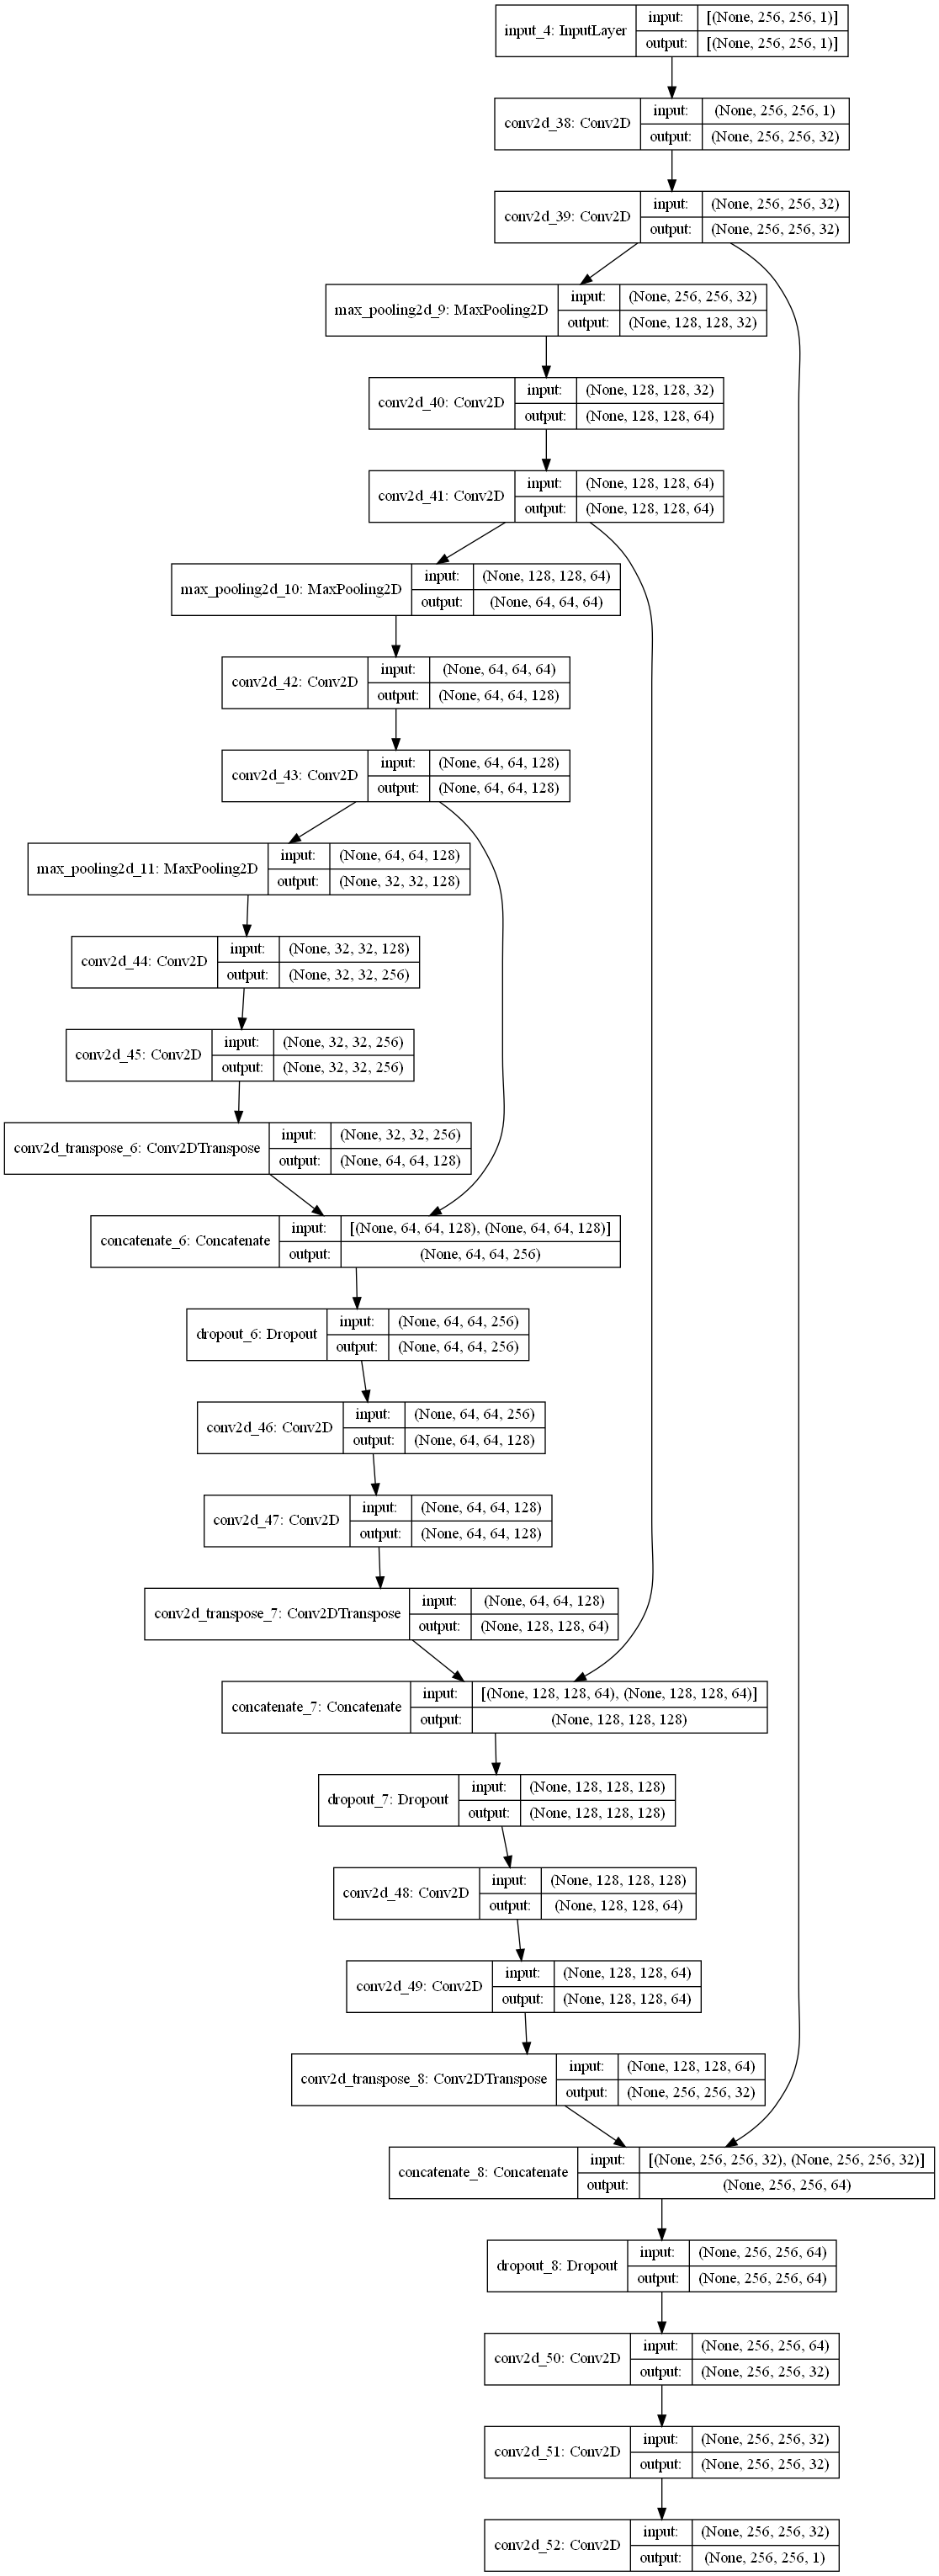

In [15]:
from tensorflow.keras.utils import plot_model

model = build_unet_plusplus((256, 256, 1))

plot_model(model, to_file='unet_plusplus.png', show_shapes=True, expand_nested=True)

In [10]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same', activation='relu')(inputs)
    x = Conv2D(num_filters, 3, padding='same', activation='relu')(x)
    return x

def up_conv_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build(input_shape):
    inputs = Input(input_shape)

    # down-sampling path
    c1 = conv_block(inputs, 32)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = conv_block(p1, 64)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = conv_block(p2, 128)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    # mid-convolutional block
    c4 = conv_block(p3, 256)

    # up-sampling path
    u3 = up_conv_block(c4, c3, 128)
    u2 = up_conv_block(u3, c2, 64)
    u1 = up_conv_block(u2, c1, 32)

    # output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(u1)

    model = Model(inputs=inputs, outputs=outputs)

    return model

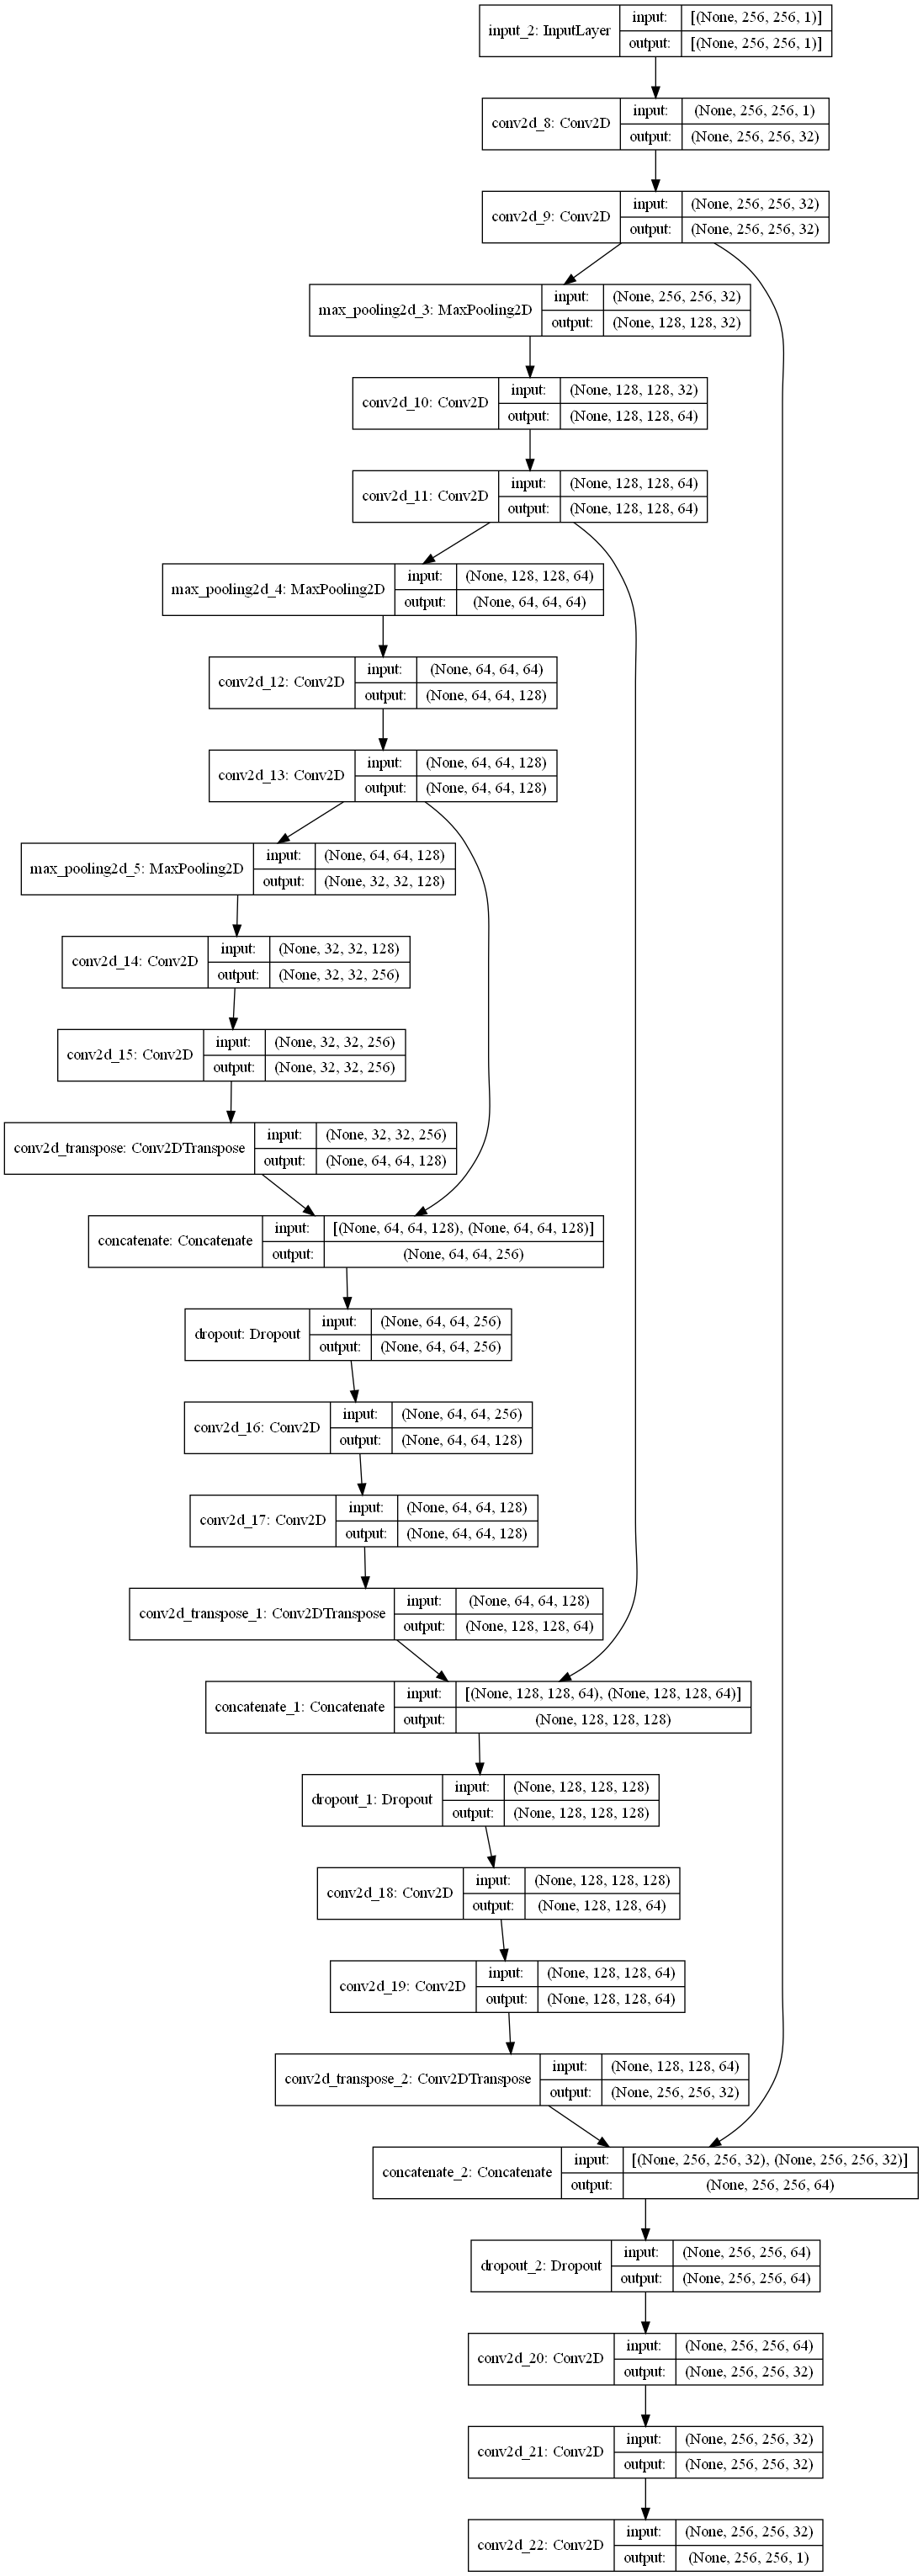

In [8]:
from tensorflow.keras.utils import plot_model

model = build((256, 256, 1))

plot_model(model, to_file='unet_plusplus.png', show_shapes=True, expand_nested=True)

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, concatenate, UpSampling2D, BatchNormalization

def conv_block(input_tensor, filters, kernel_size=3, padding='same', activation='relu'):
    x = Conv2D(filters, kernel_size, padding=padding)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def build_unet_plusplus(input_shape):
    inputs = Input(input_shape)

    # 第一层下采样
    conv1_1 = conv_block(inputs, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)

    # 第二层下采样
    conv2_1 = conv_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_1)

    # 第三层下采样
    conv3_1 = conv_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_1)

    # 第四层下采样
    conv4_1 = conv_block(pool3, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4_1)

    # 中间层
    conv5_1 = conv_block(pool4, 512)

    # 第四层上采样
    up4_2 = UpSampling2D(size=(2, 2))(conv5_1)
    up4_2 = concatenate([up4_2, conv4_1], axis=3)
    conv4_2 = conv_block(up4_2, 256)
    conv4_3 = conv_block(conv4_2, 256) # 加入深监督

    # 第三层上采样
    up3_3 = UpSampling2D(size=(2, 2))(conv4_3)
    up3_3 = concatenate([up3_3, conv3_1], axis=3)
    conv3_2 = conv_block(up3_3, 128)
    conv3_3 = conv_block(conv3_2, 128) # 加入深监督

    # 第二层上采样
    up2_4 = UpSampling2D(size=(2, 2))(conv3_3)
    up2_4 = concatenate([up2_4, conv2_1], axis=3)
    conv2_2 = conv_block(up2_4, 64)
    conv2_3 = conv_block(conv2_2, 64) # 加入深监督

    # 第一层上采样
    up1_5 = UpSampling2D(size=(2, 2))(conv2_3)
    up1_5 = concatenate([up1_5, conv1_1], axis=3)
    conv1_2 = conv_block(up1_5, 32)
    conv1_3 = conv_block(conv1_2, 32) # 加入深监督
    
    output_1 = Conv2D(1, 1, activation='sigmoid', name='output_1')(conv1_3)
    output_2 = Conv2D(1, 1, activation='sigmoid', name='output_2')(conv2_3)
    output_3 = Conv2D(1, 1, activation='sigmoid', name='output_3')(conv3_3)
    output_4 = Conv2D(1, 1, activation='sigmoid', name='output_4')(conv4_3)
    output = concatenate([output_1, output_2, output_3, output_4], axis=3, name='output')
    
    model = Model(inputs=inputs, outputs=output)
    return model

In [2]:
from tensorflow.keras.utils import plot_model

model = build((256, 256, 1))

plot_model(model, to_file='unet_plusplus.png', show_shapes=True, expand_nested=True)

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 256, 256, 1), (None, 128, 128, 1), (None, 64, 64, 1), (None, 32, 32, 1)]

In [5]:
def predict(model, x_test):
    y_pred = model.predict(x_test)
    # 将概率转换为二值化结果
    y_pred = (y_pred > 0.5).astype(np.uint8)
    # 将结果转换为图像
    return y_pred

In [9]:
from tensorflow.keras.optimizers import Adam


def train(model, x_train, y_train, batch_size, epochs):
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss=dice_loss, metrics=[miou_metric, binary_accuracy_metric])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)  

In [10]:
x_trian_input_dir = "E:\\octagon\\x_train"
y_trian_input_dir = "E:\\octagon\\y_train"
x_train = convert_images_to_vectors(x_trian_input_dir)
print("yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy\n")
y_train = convert_images_to_vectors(y_trian_input_dir)

[[0.01176471 0.02352941 0.02745098 ... 0.43529412 0.49019608 0.38039216]
 [0.05098039 0.07843138 0.09019608 ... 0.38431373 0.49019608 0.15294118]
 [0.07843138 0.20392157 0.20392157 ... 0.19215687 0.29411766 0.08627451]
 ...
 [0.2        0.17254902 0.24313726 ... 0.25882354 0.19215687 0.09411765]
 [0.38039216 0.23529412 0.14901961 ... 0.08235294 0.19215687 0.07450981]
 [0.12941177 0.14509805 0.00784314 ... 0.09411765 0.22745098 0.06666667]]
(216, 256, 256, 1)
yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(216, 256, 256, 1)


In [11]:
model = build_unet_plusplus(input_shape = (256,256,1))
train(model, x_train, y_train, 1, 100)
print("finish")

Epoch 1/100
172/172 [==============================] - 60s 338ms/step - loss: 0.4661 - mean_io_u: 0.6136 - binary_accuracy: 0.8734 - val_loss: 0.1809 - val_mean_io_u: 0.8479 - val_binary_accuracy: 0.9846
Epoch 2/100
172/172 [==============================] - 58s 336ms/step - loss: 0.1366 - mean_io_u: 0.8810 - binary_accuracy: 0.9876 - val_loss: 0.1618 - val_mean_io_u: 0.8778 - val_binary_accuracy: 0.9853
Epoch 3/100
172/172 [==============================] - 58s 336ms/step - loss: 0.1277 - mean_io_u: 0.8927 - binary_accuracy: 0.9882 - val_loss: 0.1589 - val_mean_io_u: 0.8820 - val_binary_accuracy: 0.9854
Epoch 4/100
172/172 [==============================] - 58s 336ms/step - loss: 0.1255 - mean_io_u: 0.8951 - binary_accuracy: 0.9883 - val_loss: 0.1548 - val_mean_io_u: 0.8816 - val_binary_accuracy: 0.9858
Epoch 5/100
172/172 [==============================] - 58s 336ms/step - loss: 0.1217 - mean_io_u: 0.8981 - binary_accuracy: 0.9885 - val_loss: 0.1556 - val_mean_io_u: 0.8782 - val_bina

172/172 [==============================] - 58s 336ms/step - loss: 0.0571 - mean_io_u: 0.9511 - binary_accuracy: 0.9924 - val_loss: 0.1318 - val_mean_io_u: 0.8970 - val_binary_accuracy: 0.9869
Epoch 42/100
172/172 [==============================] - 58s 336ms/step - loss: 0.0567 - mean_io_u: 0.9512 - binary_accuracy: 0.9924 - val_loss: 0.1329 - val_mean_io_u: 0.8980 - val_binary_accuracy: 0.9871
Epoch 43/100
172/172 [==============================] - 58s 336ms/step - loss: 0.0549 - mean_io_u: 0.9521 - binary_accuracy: 0.9925 - val_loss: 0.1310 - val_mean_io_u: 0.8980 - val_binary_accuracy: 0.9871
Epoch 44/100
172/172 [==============================] - 58s 336ms/step - loss: 0.0555 - mean_io_u: 0.9515 - binary_accuracy: 0.9924 - val_loss: 0.1306 - val_mean_io_u: 0.8983 - val_binary_accuracy: 0.9871
Epoch 45/100
172/172 [==============================] - 58s 336ms/step - loss: 0.0527 - mean_io_u: 0.9548 - binary_accuracy: 0.9926 - val_loss: 0.1336 - val_mean_io_u: 0.8944 - val_binary_accur

172/172 [==============================] - 58s 336ms/step - loss: 0.0400 - mean_io_u: 0.9619 - binary_accuracy: 0.9933 - val_loss: 0.1297 - val_mean_io_u: 0.8976 - val_binary_accuracy: 0.9872
Epoch 82/100
172/172 [==============================] - 58s 336ms/step - loss: 0.0403 - mean_io_u: 0.9623 - binary_accuracy: 0.9933 - val_loss: 0.1338 - val_mean_io_u: 0.8940 - val_binary_accuracy: 0.9869
Epoch 83/100
172/172 [==============================] - 58s 336ms/step - loss: 0.0400 - mean_io_u: 0.9620 - binary_accuracy: 0.9933 - val_loss: 0.1313 - val_mean_io_u: 0.8951 - val_binary_accuracy: 0.9870
Epoch 84/100
172/172 [==============================] - 58s 336ms/step - loss: 0.0403 - mean_io_u: 0.9618 - binary_accuracy: 0.9933 - val_loss: 0.1320 - val_mean_io_u: 0.8959 - val_binary_accuracy: 0.9871
Epoch 85/100
172/172 [==============================] - 58s 336ms/step - loss: 0.0397 - mean_io_u: 0.9621 - binary_accuracy: 0.9933 - val_loss: 0.1306 - val_mean_io_u: 0.8962 - val_binary_accur

In [11]:
x_test = convert_images_to_vectors("E:\\data\\x_test")
y_test = convert_images_to_vectors("E:\\data\\y_test")
model.evaluate(x_train, y_train, batch_size=1)

[[0.05098039 0.         0.01568628 ... 0.40392157 0.28235295 0.22745098]
 [0.54901963 0.36862746 0.19607843 ... 0.56078434 0.36078432 0.16078432]
 [0.99215686 0.8745098  0.6666667  ... 0.17254902 0.0627451  0.03529412]
 ...
 [0.06666667 0.03529412 0.         ... 0.09411765 0.04705882 0.00784314]
 [0.07450981 0.07058824 0.03921569 ... 0.04313726 0.         0.        ]
 [0.03529412 0.01568628 0.05490196 ... 0.05490196 0.         0.10196079]]
(30, 256, 256, 1)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(30, 256, 256, 1)
216/216 [==============================] - 26s 119ms/step - loss: 0.0617 - accuracy: 0.9874


[0.06167406216263771, 0.9874204993247986]

In [17]:
x_trian_input_dir = "E:\\data\\img"
y_trian_input_dir = "E:\\data\\label"
x_train = convert_images_to_vectors("E:\\octagon\\image")
print(x_train)
print("yyyyyyyyyyyyyy\n")
y_train = convert_images_to_vectors("E:\\octagon\\label")
print(y_train)

1.tif
10.tif
11.tif
12.tif
13.tif
14.tif
15.tif
16.tif
17.tif
18.tif
19.tif
2.tif
20.tif
21.tif
22.tif
23.tif
24.tif
25.tif
26.tif
27.tif
28.tif
29.tif
3.tif
30.tif
31.tif
32.tif
33.tif
34.tif
35.tif
36.tif
4.tif
5.tif
6.tif
7.tif
8.tif
9.tif
(180, 256, 256, 1)
[[[[0.08235294]
   [0.30980393]
   [0.45882353]
   ...
   [0.5176471 ]
   [0.7058824 ]
   [0.62352943]]

  [[0.23921569]
   [0.88235295]
   [0.94509804]
   ...
   [0.16470589]
   [0.2       ]
   [0.27058825]]

  [[0.2901961 ]
   [0.95686275]
   [0.95686275]
   ...
   [0.12941177]
   [0.07843138]
   [0.01960784]]

  ...

  [[0.2       ]
   [0.2784314 ]
   [0.39607844]
   ...
   [0.60784316]
   [0.7058824 ]
   [0.32156864]]

  [[0.39607844]
   [0.53333336]
   [0.28627452]
   ...
   [0.56078434]
   [0.7490196 ]
   [0.2627451 ]]

  [[0.5647059 ]
   [0.6784314 ]
   [0.34509805]
   ...
   [0.7490196 ]
   [0.60784316]
   [0.14901961]]]


 [[[0.08235294]
   [0.30980393]
   [0.45882353]
   ...
   [0.5176471 ]
   [0.7058824 ]
   [0.623529

In [21]:
x_pre = convert_images_to_vectors("E:\\octagon\\predict")
y_pre = predict(model, x_pre)
print(y_pre)

[[0.7058824  0.46666667 0.23529412 ... 0.08235294 0.47058824 0.95686275]
 [1.         0.70980394 0.16470589 ... 0.37254903 0.6784314  0.96862745]
 [0.7254902  0.29411766 0.11764706 ... 0.40784314 0.6666667  0.93333334]
 ...
 [0.8509804  0.85882354 0.4509804  ... 0.5254902  0.8039216  0.5411765 ]
 [0.89411765 0.9607843  0.7921569  ... 0.78431374 0.58431375 0.23137255]
 [0.88235295 0.7294118  0.8666667  ... 0.22745098 0.21176471 0.32156864]]
(8, 256, 256, 1)
[[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]

In [22]:
y_pred_image = (y_pre * 255).astype('uint8')  # 将元素值从 0/1 转换为 0/255
y_pred_image = np.squeeze(y_pred_image, axis=-1)  # 去掉最后一维，变成 (batch_size, height, width)
images = []
for i in range(y_pred_image.shape[0]):
    # 将二值张量转换为 PIL.Image 类型的图片
    img = Image.fromarray(y_pred_image[i])
    img.save('E:/octagon/y_pre/prediction_{}.png'.format(i))

In [20]:
model.save(os.path.join("E:/octagon/model", "U-Net-model-area.h5"))

In [17]:
from tensorflow.keras.models import load_model

# 加载模型
model = load_model("E:/octagon/model/U-Net-model-dice.h5", custom_objects={'dice_loss': dice_loss})